In [1]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat
from matplotlib import cm

In [2]:
config()

# Load data

## 1. PySindy

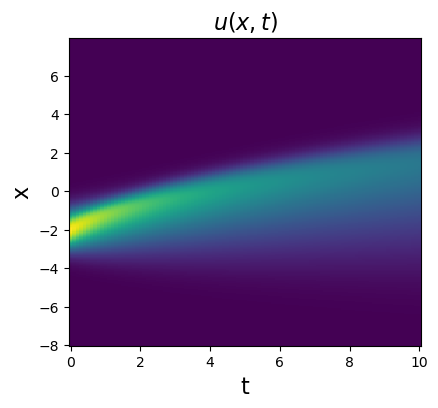

In [3]:
path = os.getcwd()
data_path = path.replace("examples", "tests/data")
# load data
data = loadmat(os.path.join(data_path, 'burgers.mat'))
t_ps = np.ravel(data['t'])
x_ps = np.ravel(data['x'])
u_ps = np.real(data['usol'])
dt_ps = t_ps[1] - t_ps[0]
dx_ps = x_ps[1] - x_ps[0]
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(t_ps, x_ps, u_ps)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

#viscosity
epsilon_ps = 0.1
# Number of temporal grid points
nt_ps = len(t_ps)
# Number of spatial grid points
nx_ps = len(x_ps)

plt.show()

## 2. Exponential init

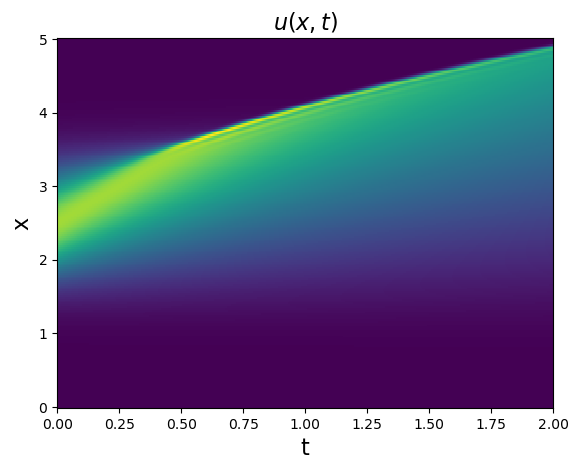

In [4]:
# Define and calculate constants and parameters

#Viscosity
# number between 0.003 and 0.3 (to maintain numerical stability)
epsilon_exp = 0.006

# Total size 
xmax = 5
# Total time
tmax = 2  

# Number of spatial grid points
nx_exp = 200
# Temporal resolution
dt_exp = 0.001

# Position vector
x_exp = np.linspace(0, xmax, nx_exp)
#  Number of temporal grid points
nt_exp = int(tmax / dt_exp)  
# Spatial resolution
dx_exp = xmax / nx_exp 
# Vector containing time points
t_exp = np.linspace(0, tmax, nt_exp)  
# Array containing velocity
u_exp = np.zeros([nx_exp, nt_exp]) 

def main_run_FDM(x,u, dt, dx, epsilon, max_time_iter):
    for t in range(max_time_iter):
        u[1:-1, t+1] = u[1:-1, t] + dt * (epsilon * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2 
                   - 0.25 * (u[2:, t]**2 - u[:-2, t]**2) / dx)
        #diffusion = epsilon * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2
        #flux = (u[2:, t]**2 - u[:-2, t]**2) /(4*dx)
        #u[1:-1, t+1] = 1/2*(u[2:, t] + u[:-2, t]) + dt * (diffusion - flux)
        #print(np.linalg.norm(u[:,t+1]))
    return u


u_exp[:, 0] = 2 * np.exp(-2 * (x_exp - 0.5 * xmax)**2)  # Initial condition
u_exp[0, :] = 0  # Boundary condition at x=0
u_exp[-1, :] = 0  #  Boundary condition at x=xmax

u_exp = main_run_FDM(x_exp, u_exp,dt_exp, dx_exp, epsilon_exp, nt_exp-1)


plt.pcolormesh(t_exp, x_exp, u_exp)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()

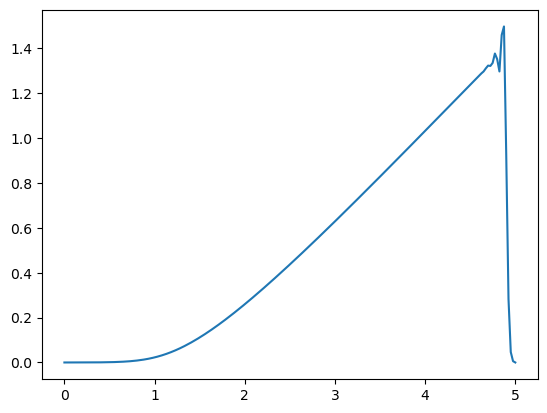

In [5]:
plt.plot(x_exp, u_exp[:, -1])
plt.show()

# Solving

In [6]:
# choose data
data_name = "exponential"
if data_name == "pysindy":
    x = x_ps
    t = t_ps
    dt_ = dt_ps
    dx = dx_ps
    u = u_ps
    epsilon = epsilon_ps
    nt = nt_ps
    nx = nx_ps
elif data_name == "exponential":
    x = x_exp
    t = t_exp
    dt_ = dt_exp
    dx = dx_exp
    u = u_exp
    epsilon = epsilon_exp
    nt = nt_exp
    nx = nx_exp

In [7]:
# define simplicial complex
tet_node_tags = np.zeros((len(x)-1,2), dtype = dt.int_dtype)
tet_node_tags[:,0] = np.arange(len(x)-1)
tet_node_tags[:,1] = np.arange(1, len(x))
node_coords = np.zeros((len(x), 2), dtype = dt.float_dtype)
node_coords[:,0] = x
S = SimplicialComplex(tet_node_tags, node_coords, is_well_centered = True)
S.get_hodge_star()
S.get_flat_PDP_weights()

In [8]:
# define solver
def main_run(u, S, epsilon, max_time_iter, flux_formulation = False):
    for t in range(max_time_iter):
        u_coch = C.CochainP0(S, u[:,t])
        dissipation = C.scalar_mul(C.star(C.coboundary(u_coch)), epsilon)
        if flux_formulation:
            flux = C.scalar_mul(C.square(u_coch), -1/2)
            mean_flux = flat(flux)
            total_flux = C.add(C.star(mean_flux), dissipation)
            balance = C.star(C.coboundary(total_flux))
            #u[1:-1, t+1] = 1/2*(u[2:, t] + u[:-2, t]) - dt_*balance.coeffs[1:-1]
            u[1:-1, t+1] = u[1:-1, t] + dt_*balance.coeffs[1:-1]
        else:
            u_mean = flat(u_coch)
            u_x = C.star(C.coboundary(C.star(u_mean)))
            uu_x = C.cochain_mul(u_coch, u_x)
            diss_balance = C.star(C.coboundary(dissipation))
            balance = C.sub(diss_balance, uu_x)
            u[1:-1,t+1] = u[1:-1,t] + dt_*balance.coeffs[1:-1]
    return u

In [9]:
# define initial and boundary conditions
u_0 = np.zeros((len(x), len(t)), dtype = dt.float_dtype)
if data_name == "pysindy":
    u_0[:,0] = u[:,0]
    u_0[0,:] = u[0,:]
    u_0[-1,:] = u[-1,:]
elif data_name == "exponential":
    u_0[:,0] =2 * np.exp(-2 * (x - 0.5 * xmax)**2) 
    u_0[0, :] = 0  
    u_0[-1, :] = 0

In [10]:
# solve
u_sol = main_run(u_0.copy(), S, epsilon, nt - 1, True)

# Plots

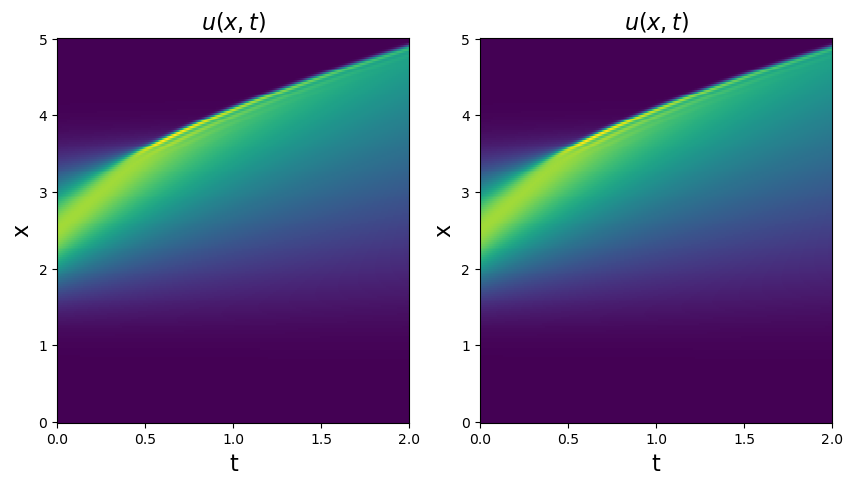

In [11]:
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x, u)
ax[1].pcolormesh(t,x,u_sol)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

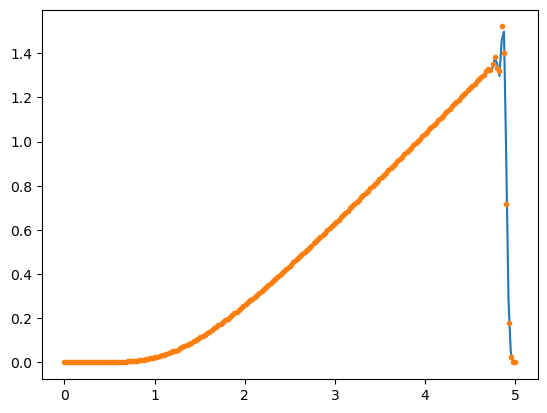

In [12]:
plt.plot(x, u[:,-1])
plt.plot(x, u_sol[:,-1], marker = ".", linewidth = 0.01)
plt.show()

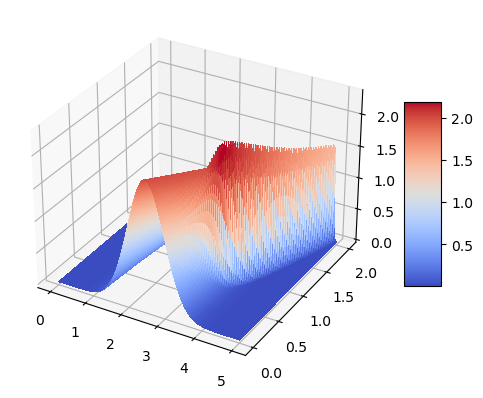

In [13]:
# 3d plot u
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x_mesh, t_mesh = np.meshgrid(x, t)
surf = ax.plot_surface(x_mesh, t_mesh, u.T, cmap=cm.coolwarm, rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

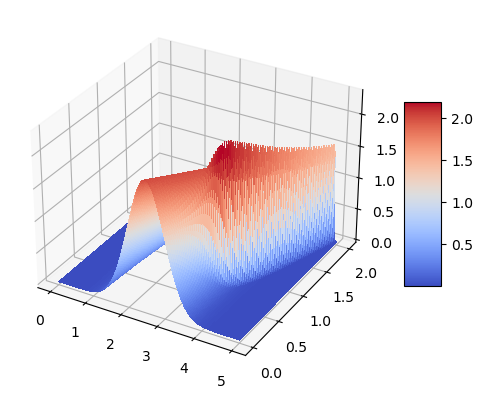

In [14]:
# 3d plot u_sol
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x_mesh, t_mesh = np.meshgrid(x, t)
surf = ax.plot_surface(x_mesh, t_mesh, u_sol.T, cmap=cm.coolwarm, rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Test with explicit solution

0.1
0.10954260812230453


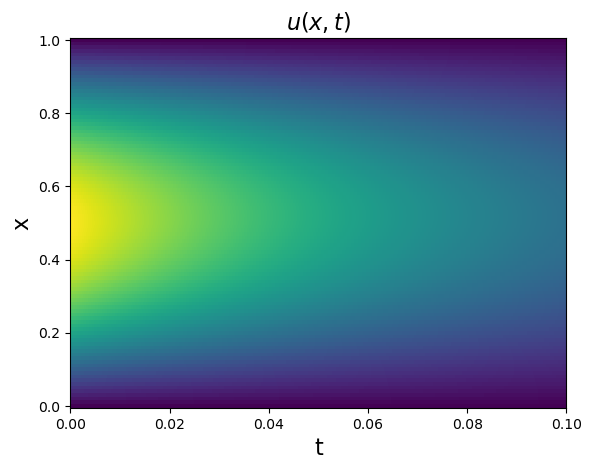

In [15]:
dx = 0.01
x = np.linspace(0, 1, int(1/dx) + 1)
dt_ = 0.00001
nt = int(0.1/dt_) + 1
t = np.linspace(0, 0.1, nt)
epsilon = 1


u_0 = np.zeros((len(x), len(t)), dtype = dt.float_dtype)
u_0[:,0] = np.sin(np.pi*x)
u_0[0,:] = 0
u_0[-1,:] = 0


u = main_run_FDM(x, u_0.copy(),dt_, dx, epsilon, nt-1)

print(x[10])
print(u[10,-1])

plt.pcolormesh(t, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()

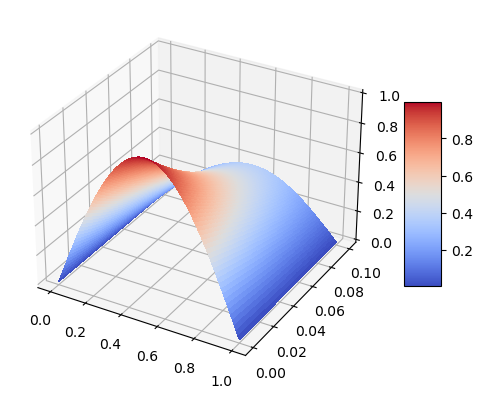

In [16]:
# 3d plot u
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x_mesh, t_mesh = np.meshgrid(x, t)
surf = ax.plot_surface(x_mesh, t_mesh, u.T, cmap=cm.coolwarm, rcount=nx, ccount=nt,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [17]:
# regenerate mesh
# define simplicial complex
tet_node_tags = np.zeros((len(x)-1,2), dtype = dt.int_dtype)
tet_node_tags[:,0] = np.arange(len(x)-1)
tet_node_tags[:,1] = np.arange(1, len(x))
node_coords = np.zeros((len(x), 2), dtype = dt.float_dtype)
node_coords[:,0] = x
S = SimplicialComplex(tet_node_tags, node_coords, is_well_centered = True)
S.get_hodge_star()
S.get_flat_PDP_weights()

In [18]:
u_sol = main_run(u_0.copy(), S, epsilon, nt - 1, True)

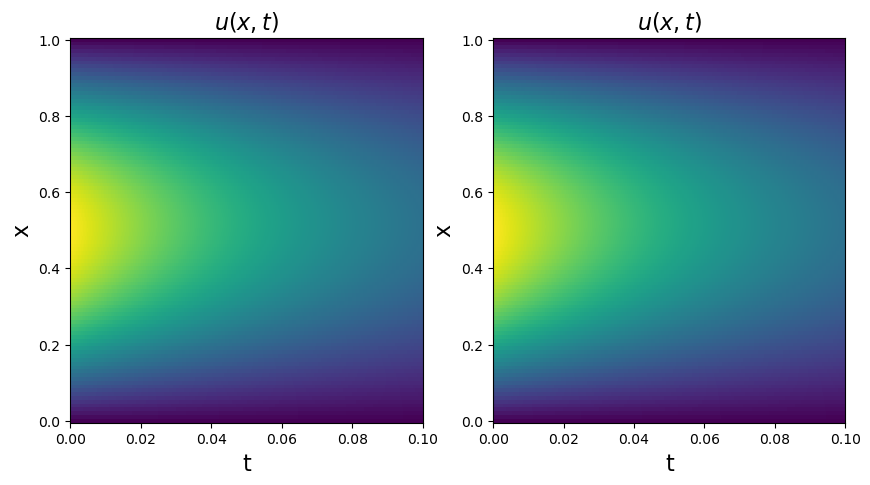

In [19]:
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t, x, u)
ax[1].pcolormesh(t,x,u_sol)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$u(x, t)$', fontsize=16)
plt.show()

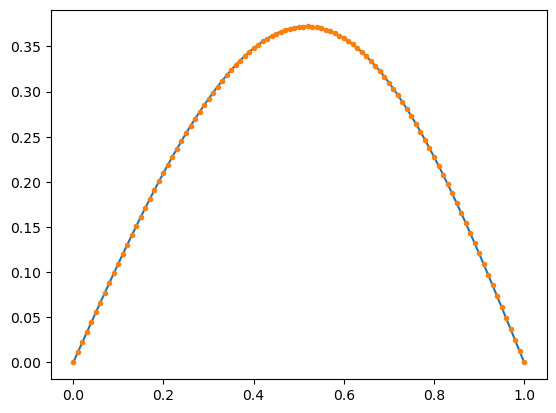

In [20]:
plt.plot(x, u[:,-1])
plt.plot(x, u_sol[:,-1], marker = ".", linewidth = 0.01)
plt.show()